# Simple OFDM example using the pytorch

In [161]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from OFDM_SDR_Functions_torch_v2 import *
from SDR_Pluto_v2 import *
from config import * # OFDM Configuration is stored in config.py
import torch
import random


Qm = 4  # bits per symbo
SDR_TX_Frequency = 3500e6 # TX frequency in Hz

# Channel Simulation Parameters in case no sdr
ch_SINR = 25  # SINR target for channel emulation
n_taps = 2 # max number of taps
max_delay_spread = 3 # samples. Note that 128*15kHz sample duration is already ~500ns.
velocity = 30 # velocity in m/s

# SDR Configuration
use_sdr = False # Set to `True` to use SDR for transmission and reception, `False` to run channel simulation.
randomize_tx_gain = True # randomize tx gain
tx_gain_lo = -30 # min tx gain
tx_gain_hi = -30 # max tx gain
rx_gain = 0 # rx gain



## Create modulation mapping tables

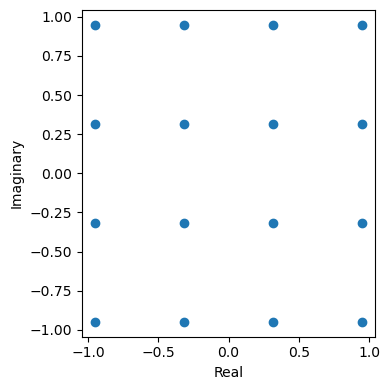

In [162]:
mapping_table_QPSK, de_mapping_table_QPSK = mapping_table(2) # mapping table QPSK (e.g. for pilot symbols)
mapping_table_Qm, de_mapping_table_Qm = mapping_table(Qm, plot=True) # mapping table for Qm

## Creating an OFDM Block Mask for Resource Allocations

The values in the mask indicate the use as follows:

- `0`: The PRB is null power.
- `1`: The PRB is PDSCH.
- `2`: Pilot symbols
- `3`: DC


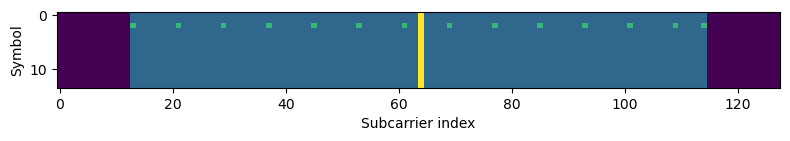

In [163]:
OFDM_mask = OFDM_block_mask(S=S,F=F, Fp=Fp, Sp=Sp, FFT_offset=FFT_offset,plotOFDM_block=True)

## Pilot Symbol Sequence Creation

In [164]:
pilot_symbols = pilot_set(OFDM_mask, 1)

## Initialize and Start The SDR

Create a PlutoSDR object and configure it with the appropriate transmission parameters including RF bandwidth, carrier frequency, and hardware gain.

In [165]:
if use_sdr:
     SDR_1 = SDR(SDR_RX_IP=SDR_RX_IP, 
                           SDR_TX_IP=SDR_TX_IP,
                           SDR_TX_FREQ=SDR_TX_Frequency, 
                           SDR_TX_GAIN=tx_gain, 
                           SDR_RX_GAIN = rx_gain, 
                           SDR_TX_SAMPLERATE=SampleRate, 
                           SDR_TX_BANDWIDTH=SDR_TX_BANDWIDTH)
     SDR_1.SDR_TX_start()
     SDR_1.SDR_RX_start()

## Data Stream Creation, RE mapping, Modulation, FFT, and Cyclic Prefix Addition

`Create_OFDM_data` - function utilises various OFDM functions to: 
- create the payload data, 
- map it on OFDM block
- QAM modulate it 
- apply FFT 
- add cyclic prefix. 

Output is a tuple containing the original bits, and the IQ signal ready for transmission.

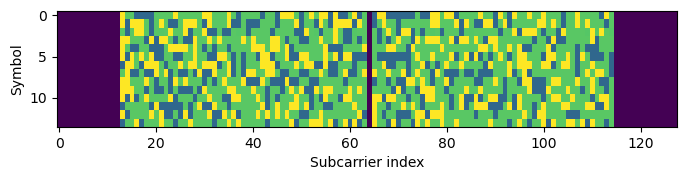

In [166]:
def create_OFDM_data():
    pdsch_bits, pdsch_symbols = create_payload(OFDM_mask, Qm, mapping_table_Qm, power=1) # create PDSCH data and modulate it
    Modulated_TTI = RE_mapping(OFDM_mask, pilot_symbols, pdsch_symbols, plotOFDM_block=True) # map the PDSCH and pilot symbols to the TTI
    TD_TTI_IQ = IFFT(Modulated_TTI) # perform the FFT
    TX_Samples = CP_addition(TD_TTI_IQ, S, FFT_size, CP) # add the CP
    if use_sdr:
        zeros = torch.zeros(leading_zeros, dtype=TX_Samples.dtype) # create leading zeros for estimating noise floor power
        TX_Samples = torch.cat((zeros, TX_Samples), dim=0) # add leading zeros to TX samples
    return pdsch_bits, TX_Samples

pdsch_bits, TX_Samples = create_OFDM_data()

## Radio Channel - Transmitting and Receiving OFDM Symbols

Either simulation or SDR are possible.

In [167]:
def radio_channel(use_sdr, tx_signal, tx_gain, rx_gain, ch_SINR):
    if use_sdr:
        if randomize_tx_gain:
            tx_gain = random.randint(tx_gain_lo, tx_gain_hi) # add random gain to the TX gain
        SDR_1.SDR_gain_set(tx_gain, rx_gain) # set the gains
        print("TX Gain: ", tx_gain, ", RX Gain: ", rx_gain)
        SDR_1.SDR_TX_send(SAMPLES=tx_signal, max_scale=TX_Scale, cyclic=True) # start transmitting the symbols in cyclic mode
        rx_signal = SDR_1.SDR_RX_receive(len(tx_signal)*4) # receive the signal with 4 times more samples than the length of the transmitted signal.
        SDR_1.SDR_TX_stop() # stop the transmission
    else:
        rx_signal, h = apply_multipath_channel_dop(tx_signal, 
                                                   max_n_taps=n_taps, 
                                                   max_delay=max_delay_spread, 
                                                   random_start=True, 
                                                   repeats=3, 
                                                   SINR=ch_SINR, 
                                                   leading_zeros=leading_zeros,
                                                   fc=SDR_TX_Frequency, 
                                                   velocity=velocity,
                                                   fs=SampleRate,
                                                   randomize=False)
        print(h)
    return rx_signal

RX_Samples = radio_channel(use_sdr=use_sdr, tx_signal = TX_Samples, tx_gain = tx_gain, rx_gain = rx_gain, ch_SINR=ch_SINR) 


tensor([-0.0033-0.0136j,  0.0060-0.0015j,  0.0000+0.0000j])


### Power Spectral Densities of transmitted and received signals

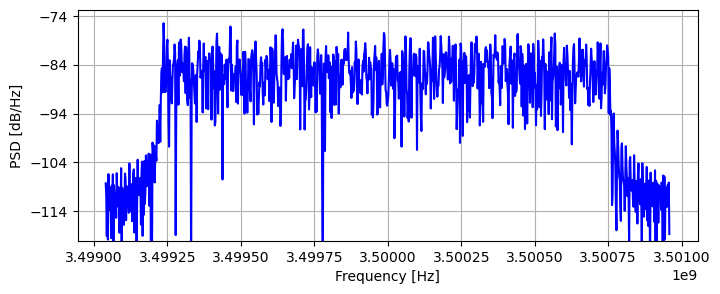

In [168]:
PSD_plot(TX_Samples, SampleRate, SDR_TX_Frequency, 'TX')

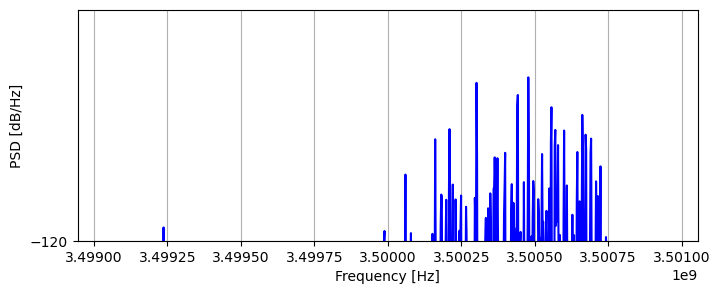

In [169]:
PSD_plot(RX_Samples, SampleRate, SDR_TX_Frequency, 'RX')

## Synchronization

Synchronization is achieved through correlation. `sync_iq` output is a tuple with two estimates of the start index. First one is based on correlation threshold, and the second one is the maximum correlation index.


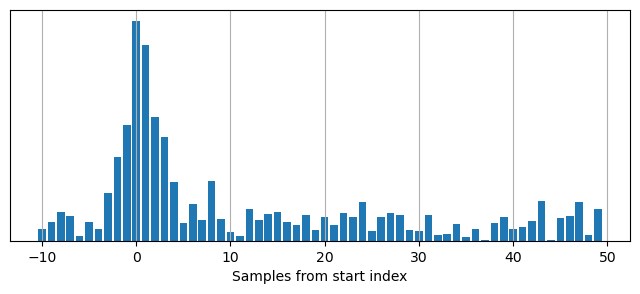

In [170]:
symbol_index, symbol_index_maxarg=sync_iq(TX_Samples, RX_Samples, leading_zeros=leading_zeros, threshold= 0, plot=True)
if use_sdr:
    symbol_index_maxarg = symbol_index_maxarg + leading_zeros

The graph shows the measured taps exceeding the threshold at resolution of one sample.

## SINR calculation

Null symbols were added into the beginning of each transmission to allow measuring the noise level at the receiver. The average power of transmitted symbols is divided by the average power of those null symbols. Note that this gives only a rough estimate, as in this simple implementation the null symbols outside the transmit bandwidth are included in transmitted power calculation.

$\text{SINR} = \frac{\text{Signal Power}}{\text{Interference Power} + \text{Noise Power}}$


In [171]:
SINR_m, noise_power, signal_power = SINR(RX_Samples, symbol_index_maxarg, leading_zeros) # calculate the SINR

## Cyclic Prefix Removal

The cyclic prefix (CP) was added to each symbol to mitigate inter-symbol interference caused by multipath propagation. Once the signal is received, the CP must be removed to proceed with demodulation and data recovery.

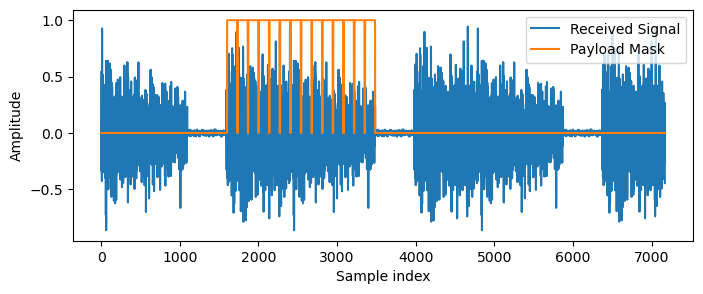

In [172]:
RX_NO_CP = CP_removal(RX_Samples, symbol_index_maxarg, S, FFT_size, CP, plotsig=True) # remove the cyclic prefix
RX_NO_CP = RX_NO_CP / torch.max(torch.abs(RX_NO_CP)) # normalize the signal

## Convert the the time domain OFDM signal into frequency domain

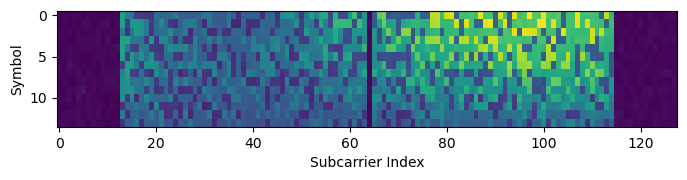

In [173]:
OFDM_mask = extract_middle_subcarriers(OFDM_mask, FFT_size_RX)
IQ_DFT = DFT(RX_NO_CP, plotDFT=True) # perform the DFT on the received signal and plot the result
IQ_DFT = extract_middle_subcarriers(IQ_DFT, FFT_size_RX)

## Channel Estimation

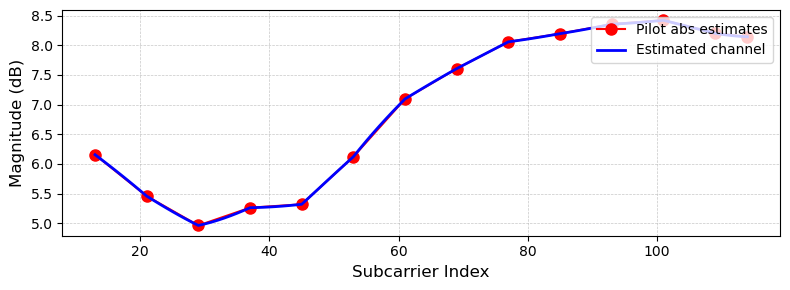

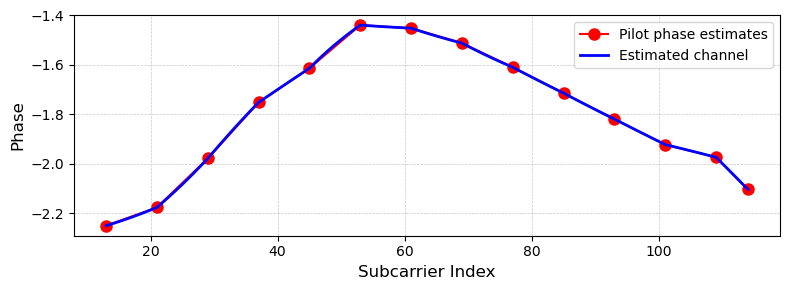

In [174]:

H_estim = channelEstimate_LS(OFDM_mask, pilot_symbols, F, FFT_offset_RX, Sp, IQ_DFT, plotEst=True) # estimate the channel using least squares and plot

## Equalization in OFDM Systems

Equalization aims to mitigate the phase and amplitude variations introduced by the communication channel.

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


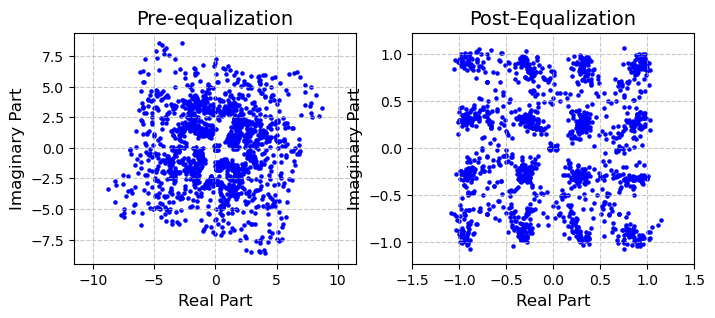

In [175]:
OFDM_demod_no_offsets = remove_fft_Offests(IQ_DFT, F, FFT_offset_RX) # remove the FFT offsets and DC carrier from the received signal
equalized_H_estim = equalize_ZF(OFDM_demod_no_offsets, H_estim, F, S, plotQAM=True) # equalize the channel using ZF

## Payload Symbols extraction

The payload in an OFDM system refers to the actual data transmitted, excluding overheads like cyclic prefixes, pilot symbols, and any additional signaling or control information. 

In [176]:
QAM_est = get_payload_symbols(OFDM_mask, equalized_H_estim, FFT_offset_RX, F) # get the payload symbols from the equalized signal

## Converting OFDM Symbols to Data

After receiving and processing the OFDM symbols, the final step is to convert them back into the original data stream. This process involves demodulation, demapping and combining the information to data stream.

In [177]:
PS_est, hardDecision = Demapping(QAM_est, de_mapping_table_Qm) # demap the symbols back to codewords
bits_est = PS(PS_est) # convert the codewords to the bitstream
print(bits_est)

tensor([1, 1, 1,  ..., 0, 0, 1], dtype=torch.int32)


## Calculating Bit Error Rate (BER) 

Understanding the performance of an OFDM system requires evaluating key metrics like Bit Error Rate (BER) and Signal-to-Interference-plus-Noise Ratio (SINR). The received data bits are compared to the original transmitted bits to identify errors.

$\text{BER} = \frac{\text{Number of Bit Errors}}{\text{Total Number of Transmitted Bits}}$


In [178]:
error_count = torch.sum(bits_est != pdsch_bits.flatten()).float()  # Count of unequal bits
error_rate = error_count / bits_est.numel()  # Error rate calculation
BER = torch.round(error_rate * 1000) / 1000  # Round to 3 decimal places
print(f"BER: {BER:.3f}, SINR: {SINR_m:.1f}dB") # print the BER and SINR


BER: 0.057, SINR: 27.3dB


In [ ]:
from models_local import *
device="cpu"
model = RXModel_2(Qm).to(device)
checkpoint_path = 'data/models/rx_model_4_8_148.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
TTI_mask_RE_3d = OFDM_mask.unsqueeze(-1).expand(S, FFT_size_RX, Qm) # 14, 128, 4

def labels4d23d(batch_size, labels):
    TTI_mask_indices = torch.where(OFDM_mask==1) # 1387
    TTI_3d = torch.zeros((batch_size, OFDM_mask.shape[0], OFDM_mask.shape[1], 4)).to(device)
    row_indices, col_indices = TTI_mask_indices
    row_indices.to(device)
    col_indices.to(device)
    TTI_3d[:, row_indices, col_indices, :] = labels.clone().detach().to(device)
    return TTI_3d

# NN receiver ###################################################
test_labels, sinr = pdsch_bits, SINR_m
# test labels 1400,1
IQ_DFT = IQ_DFT.unsqueeze(0)
IQ_DFT = IQ_DFT / torch.max(torch.abs(IQ_DFT)) 
test_pdsch_iq_real = IQ_DFT.real.float()
test_pdsch_iq_imag = IQ_DFT.imag.float()
test_pdsch_iq_nn = torch.stack([test_pdsch_iq_real, test_pdsch_iq_imag], dim=1).to(device)

test_outputs = model((test_pdsch_iq_nn))
binary_predictions = test_outputs.squeeze()[TTI_mask_RE_3d==1]
binary_predictions = torch.round(binary_predictions)

# BER for NN
test_labels = labels4d23d(1, test_labels)
test_labels = test_labels.squeeze()[TTI_mask_RE_3d==1]
error_count = torch.sum(binary_predictions != test_labels).float()  # Count of unequal bits
wrongs_nn = (binary_predictions.flatten() != test_labels.flatten()).float().tolist()

error_rate = error_count / len(test_labels.flatten())  # Error rate calculation
BER_NN = torch.round(error_rate * 1000) / 1000  # Round to 3 decimal places
print(f"BER_NN: {BER_NN:.3f}, SINR: {SINR_m:.1f}dB") # print the BER and SINR

BER_NN: 0.001, SINR: 27.3dB


## Visualize bit errors

Bit error visualization. As there are $Qm$ bits per symbol, the color range refer to bit errors per symbol from purple 0 to yellow Qm errors per symbol.

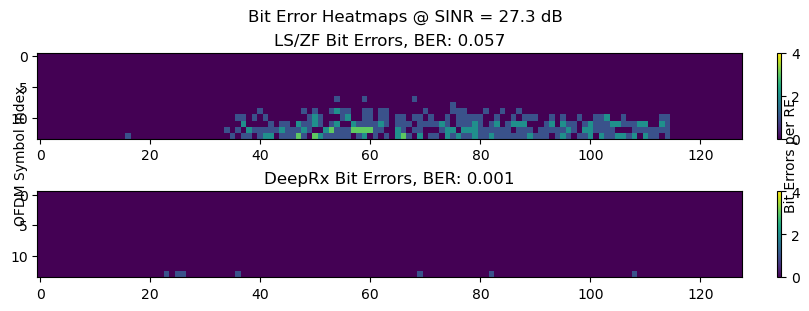

In [180]:

# --- LS/ZF Receiver Errors ---
OFDM_block = np.zeros(OFDM_mask.shape)  # F subcarriers × S symbols
errors = (bits_est != pdsch_bits.flatten()).reshape(-1, Qm).sum(axis=1)
OFDM_block[OFDM_mask == 1] = errors

# --- DeepRx Errors ---
TTI_t = np.zeros(OFDM_mask.shape)
n_symbols = int(len(binary_predictions.squeeze()) / Qm)
wrongs_nn_x = np.array(wrongs_nn).astype(int).reshape([n_symbols, Qm]).sum(axis=1)
TTI_t[OFDM_mask == 1] = wrongs_nn_x   # Normalize to bit error rate

vmin = 0
vmax = 4

# --- Plotting both heatmaps ---
fig, axs = plt.subplots(2, 1, figsize=(plot_width, 3), constrained_layout=True)
fig.text(0.01, 0.5, 'OFDM Symbol index', va='center', rotation='vertical', fontsize=10)
fig.text(0.99, 0.5, 'Bit Errors per RE', va='center', rotation='vertical', fontsize=10, ha='right')

# Plot LS/ZF
im0 = axs[0].imshow(OFDM_block, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax)
axs[0].set_title('LS/ZF Bit Errors, BER: {:.3f}'.format(BER))
axs[0].set_xlabel('')
axs[0].set_ylabel('')
fig.colorbar(im0, ax=axs[0], orientation='vertical', label='', shrink=1.0)


im1 = axs[1].imshow(TTI_t, interpolation='nearest', aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax)
axs[1].set_title('DeepRx Bit Errors, BER: {:.3f}'.format(BER_NN))
axs[1].set_xlabel('')
axs[1].set_ylabel('')
fig.colorbar(im1, ax=axs[1], orientation='vertical', label='', shrink=1.0)

# Save figure
fig.suptitle('Bit Error Heatmaps @ SINR = {:.1f} dB'.format(SINR_m), fontsize=12)

if save_plots:
    plt.savefig(f'pics/bit_errors_comparison_{Qm}_{Fp}.png', bbox_inches='tight')

plt.show()